In [2]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from torch.autograd import Variable
import os
import math
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

# Install PyTorch
Go to https://pytorch.org and setup on your laptop.

# Basics

## Create tensors & variables

In [6]:
# Create a new tensor
print(torch.zeros(3, 2))
print(torch.rand(5, 3))
print(torch.from_numpy(np.random.rand(5, 3)))
print(torch.rand(5, 3).numpy())
print(Variable(torch.rand(5, 3)))

tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
tensor([[0.9066, 0.6281, 0.4208],
        [0.9331, 0.0390, 0.1524],
        [0.4908, 0.2655, 0.7330],
        [0.8463, 0.5597, 0.0627],
        [0.6750, 0.9399, 0.6250]])
tensor([[0.3542, 0.2902, 0.5701],
        [0.9168, 0.5717, 0.4170],
        [0.8914, 0.1321, 0.7495],
        [0.9493, 0.4972, 0.1649],
        [0.8055, 0.0451, 0.0830]], dtype=torch.float64)
[[0.5198625  0.7084987  0.09654856]
 [0.7380203  0.7581415  0.85936916]
 [0.9355981  0.03811437 0.05298316]
 [0.7794941  0.9653019  0.33427566]
 [0.13891041 0.5990428  0.03665537]]
tensor([[0.9086, 0.3767, 0.3091],
        [0.7848, 0.0021, 0.7962],
        [0.0778, 0.1763, 0.1451],
        [0.6434, 0.2451, 0.3797],
        [0.1420, 0.5535, 0.4894]])


## Operations

In [16]:
# operations
print('Elementwise addition')
x = torch.rand(5, 3)
y = torch.rand(5, 3)
print(x + y)

print('\nElementwise multiplication')
x = torch.rand(5, 3)
y = torch.rand(5, 3)
print(x * y)

print('\nBroadcast')
x = torch.ones(5, 3)
y = torch.ones(5, 1)
print(x * y)

print('\nMatrix multiplication')
x = torch.ones(1, 3)
y = torch.ones(3, 5)
print(torch.mm(x, y))

print('\nBatch Matrix multiplication')
x = torch.ones(10, 1, 3)
y = torch.ones(10, 3, 5)
print(torch.bmm(x, y))

print("\nIndexing")
print(torch.ones(3, 3)[0:1, :])

Elementwise addition
tensor([[0.9389, 0.8336, 1.7184],
        [0.1799, 0.7221, 0.4492],
        [0.7434, 0.8490, 1.3846],
        [1.1529, 0.6120, 0.5080],
        [0.5227, 1.0533, 1.1295]])

Elementwise multiplication
tensor([[0.4042, 0.2502, 0.1936],
        [0.0760, 0.0545, 0.1601],
        [0.1805, 0.1004, 0.4132],
        [0.0255, 0.0374, 0.3714],
        [0.0390, 0.0289, 0.4172]])

Broadcast
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

Matrix multiplication
tensor([[3., 3., 3., 3., 3.]])

Batch Matrix multiplication
tensor([[[3., 3., 3., 3., 3.]],

        [[3., 3., 3., 3., 3.]],

        [[3., 3., 3., 3., 3.]],

        [[3., 3., 3., 3., 3.]],

        [[3., 3., 3., 3., 3.]],

        [[3., 3., 3., 3., 3.]],

        [[3., 3., 3., 3., 3.]],

        [[3., 3., 3., 3., 3.]],

        [[3., 3., 3., 3., 3.]],

        [[3., 3., 3., 3., 3.]]])

Indexing
tensor([[1., 1., 1.]])


# Task: Digit Recogniton using Feedforward Neural Networks (FNN)

## Introduction
The goal is to label images of 10 handwritten digits of “zero”, “one”,..., “nine”. The images are 28 by 28 in size (MNIST dataset), which we will be represented as a vector x of dimension 784 by listing all the pixel values in raster scan order. The labels t are 0,1,2,...,9 corresponding to 10 classes as written in the image. There are 3000 training cases, containing 300 examples of each of 10 classes, 1000 validation (100 examples of each of 10 classes), and 3000 test cases (300 examples of each of 10 classes). they can be found in the file digitstrain.txt, digitsvalid.txt and digitstest.txt.

### Download data
If you clone this github repo, then the data should already be in the folder. 

If you are starting from your own folder, then please download the training/validation/testing data at https://drive.google.com/file/d/1hw-WeCe0EVZW34Y2T7_VE5o7XbOd0bdy/view?usp=sharing

Please uncompress the data and put them in ./data folder of your current directory.

### Data Format
digitstrain.txt contains 3000 lines. Each line contains 785 numbers (comma delimited): the first 784 real-valued numbers correspond to the 784 pixel values, and the last number denotes the class label: 0 corresponds to digit 0, 1 corresponds to digit 1, etc. digitsvalid.txt and digitstest.txt contain 1000 and 3000 lines and use the same format as above. 

# Process Data

1. Load data in terms of input and output pairs (x, y)
2. Split training data into mini batches
3. Random shuffle data at the begining of each epoch
4. Streamline the batch loader

In [18]:
class DataReader(object):
    def __init__(self, path):
        print "Reading data from %s" % path
        self.path = path
        train = self.read_file("digitstrain.txt")
        self.train_x = train[:, 0:-1]
        self.train_y = train[:, -1].astype(int)
        print("Read %d train samples" % len(self.train_y))

        dev = self.read_file("digitsvalid.txt")
        self.dev_x = dev[:, 0:-1]
        self.dev_y = dev[:, -1].astype(int)
        print("Read %d dev samples" % len(self.dev_y))

        test = self.read_file("digitstest.txt")
        self.test_x = test[:, 0:-1]
        self.test_y = test[:, -1].astype(int)
        print("Read %d test samples" % len(self.test_y))

        # get meta
        self.num_classes = np.max(self.train_y) + 1
        self.input_size = self.train_x.shape[1]
        self.indexes = range(len(self.train_y))
        self.train_size = len(self.train_y)
        self.batch_size = 32

    def read_file(self, name):
        data = None
        with open(os.path.join(self.path, name), 'rb') as f:
            lines = f.readlines()
            for idx, l in enumerate(lines):
                new_row = map(float, l.split(','))
                if data is None:
                    data = np.zeros((len(lines), len(new_row)))
                data[idx, :] = new_row
        return data

    def init(self, batch_size):
        # shuffle
        self.batch_size = batch_size
        np.random.shuffle(self.indexes)
        return int(math.ceil(self.train_size / float(batch_size)))

    def get_batch(self, i):
        selected_idx = self.indexes[i*self.batch_size : (i+1)*self.batch_size]
        return self.train_x[selected_idx, :], self.train_y[selected_idx]

# Build Model
Let's build a 1-layer feedforward neural network

1. Variable in PyTorch
2. Use log_softmax instead of softmax for stability

In [19]:
class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, non_linear='tanh'):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.non_linear = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        var_x = Variable(torch.from_numpy(x).float())
        logitis = self.fc2(self.non_linear(self.fc1(var_x)))
        return nn.functional.log_softmax(logitis, dim=1)

# Evaluate the Model

It's a classification problem, so we evalaute in terms of:
1. negative loglilhood (or cross entropy)
2. accuracy

In [20]:
def eval(data_x, data_y, model, loss_func, name):
    model.eval()
    log_py = model(data_x)
    y = Variable(torch.from_numpy(data_y).long())
    l = loss_func(log_py, y).item()
    
    pred = np.argmax(log_py.data.numpy(), axis=1)
    acc = np.mean(pred == data_y)
    print "%s loss %f and acc %f " % (name, l, acc)
    return l, acc

# Training the Model

We need:
1. a model
2. a dataloader
3. a loss function
4. an optimizier

We need to track:
1. training loss
2. validation loss (why ??)

In [25]:
NUM_EPOCH = 20
BATCH_SIZE = 10
LR = 0.01
MOMENTUM = 0.9
L2_DECAY = 0.0

data_loader = DataReader('data')
model = FNN(input_size=784, hidden_size=300, output_size=10)
nll_loss = nn.NLLLoss()
op = torch.optim.SGD(model.parameters(), lr=LR, 
                     momentum=MOMENTUM, weight_decay=L2_DECAY)

train_metric, dev_metric = [], []
for i in range(NUM_EPOCH):
    print("Epoch %d" % i)
    num_batches = data_loader.init(batch_size=BATCH_SIZE)
    model.train()
    for b in range(num_batches):
        x, y = data_loader.get_batch(b)
        pred_y = model(x)
        y = Variable(torch.from_numpy(y).long())
        loss = nll_loss(pred_y, y)
        op.zero_grad()
        loss.backward()
        op.step()

    train_metric.append(eval(data_loader.train_x, data_loader.train_y, model, nll_loss, "TRAIN"))
    dev_metric.append(eval(data_loader.dev_x, data_loader.dev_y, model, nll_loss, "DEV"))

Reading data from data
Read 3000 train samples
Read 1000 dev samples
Read 3000 test samples
Epoch 0
TRAIN loss 0.392952 and acc 0.885667 
DEV loss 0.475626 and acc 0.855000 
Epoch 1
TRAIN loss 0.242212 and acc 0.930333 
DEV loss 0.359394 and acc 0.888000 
Epoch 2
TRAIN loss 0.159888 and acc 0.955667 
DEV loss 0.313527 and acc 0.902000 
Epoch 3
TRAIN loss 0.118524 and acc 0.972333 
DEV loss 0.307175 and acc 0.901000 
Epoch 4
TRAIN loss 0.099016 and acc 0.972000 
DEV loss 0.310898 and acc 0.907000 
Epoch 5
TRAIN loss 0.060242 and acc 0.987667 
DEV loss 0.275104 and acc 0.916000 
Epoch 6
TRAIN loss 0.054890 and acc 0.991667 
DEV loss 0.286983 and acc 0.911000 
Epoch 7
TRAIN loss 0.031112 and acc 0.997667 
DEV loss 0.256927 and acc 0.925000 
Epoch 8
TRAIN loss 0.026915 and acc 0.996667 
DEV loss 0.280596 and acc 0.920000 
Epoch 9
TRAIN loss 0.016776 and acc 1.000000 
DEV loss 0.269390 and acc 0.920000 
Epoch 10
TRAIN loss 0.013842 and acc 1.000000 
DEV loss 0.263217 and acc 0.926000 
Epoch

# Visualize the Model Performance

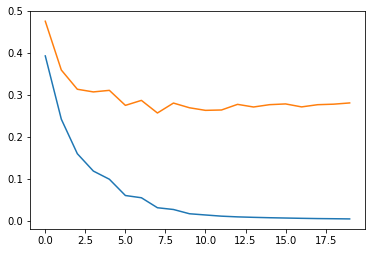

In [26]:
plt.plot([l for l, a in train_metric])
plt.plot(np.array([l for l, a in dev_metric]))

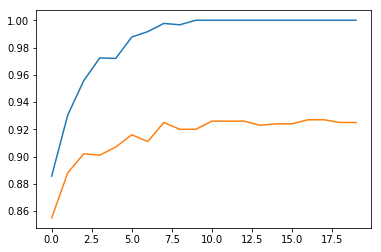

In [27]:
plt.plot([a for l, a in train_metric])
plt.plot([a for l, a in dev_metric])

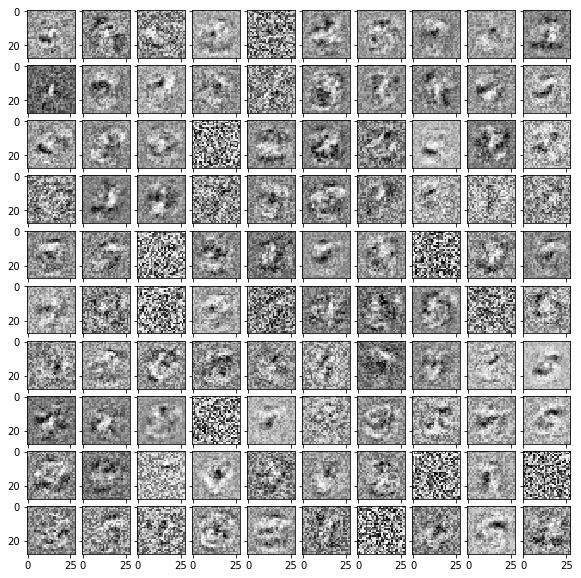

In [143]:
fc1_w = model.fc1.weight.t()
filters = np.reshape(fc1_w.data.numpy(), [28, 28, 300])
fig = plt.figure(1, (10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(10, 10),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                )

for i in range(100):
    grid[i].imshow(filters[:,:, i], cmap='Greys_r')  # The AxesGrid object work as a list of axes.

plt.show()

# Tune your models
Parameters you can tune:
1. Model architecture
    - Hidden layer size [50, 100, 300, 600]
    - Number of hidden layers [1, 2, 3]
    - Dropout [0.0, 0.3, 0.5]
2. Optimization
    - Optimizer type 
    - Learning rate [0.0, 0.5, 0.9]
    - Momentum
    - Gradient clipping
    - L2 weight decay
    - L1 weight decay